# Minihack Crossing River
**Team**: Can do (M)AI \
**Members**: Chiara Cecchetti, Nicola Emmolo, Andrea Piras, Jacopo Raffi \
**Course**: Artificial Intelligence Fundamentals 2023/2024

## Introduction
The project is based on the standard "River" environment <a href="#cite-1">[1]</a> from the MiniHack Environment Zoo.\
The final goal of the agent is to reach the stairs, which are on the other side of the river. To do this, the agent must push a boulder into the river. After that the agent can cross it; in Nethack, swimming across a river could prove fatal for the agent <a href="#cite-river_drown">[2]</a>.

The goal of the project is to find a solution that is able to complete as many games as possible in the most efficient way in terms of the number of steps performed.

### Methodologies
Two solutions to the problem are described and analyzed in the notebook. The first naive solution is an offline approach to the problem, the agent simply executes the initial computed plan without considering changes in the environment. \
However, as will be shown later, this is not sufficient, so an online approach was developed to solve the problem. In both solutions, pathfinding is based on the classic A* algorithm in order to optimize the number of steps performed by the agent.

### Assessment
At the end of the notebook, the empirical evaluations carried out for the assessment of the final solution are presented. In particular, three metrics are considered:
* The percentage of success;
* The average number of steps;
* The average execution time.
 

## Imports required

In [1]:
import gym
import minihack
import numpy as np
import math
import matplotlib.pyplot as plt
import IPython.display as display
from typing import Tuple, List
from utils import *
from algorithms import *
from logic import *
from evaluation import *

/home/jacopo/minihack/lib/python3.9/site-packages/ale_py/roms/__init__.py:89: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  ROMS = resolve_roms()


## MInihack River Environment
Befor discussing both solutions, it is important to describe the environment in which the agent performs its plans.\
Taking into account the standard description, the environment's types are as follows:
- Partially observable;
- Non-Deterministic;
- Episodic;
- Static, the state doesn't change until the agent has performed an action and there is no time limit for choosing an action;
- Discrete;
- Single-agent.

The environment "Minihack-River-Narrow-V0", one of the standard environments of the MiniHack Environment Zoo, without any fixed seeds changes at each execution following a random uniform distribution. In particular, the initial position of the agent, the position of the boulders and consequently the visibility of the environment(including the visibility of the river) are different.

To make this report easier to read and follow, the seeds for creating the environment are fixed, but only for the demonstration parts.\
The evaluation takes into account environments that changes at each execution.

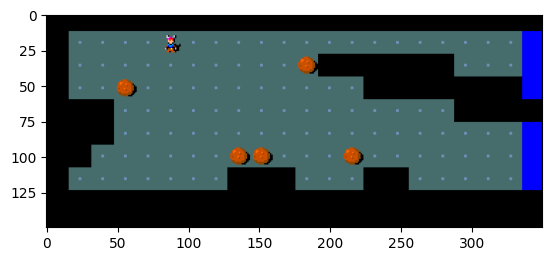

In [2]:
state, env = create_env() # create the environment without fixed seed
plt.imshow(state['pixel'][100:250, 400:750]) 
game_map = state['chars'] # state of the game map
game = state['pixel']

## First solution: Offline A*
The first approach involves using the traditional A* algorithm, with basic logic designed only to detect objects and manoeuvre the boulders into the river in the correct way. This method, referred to as offline A*, is unable to solve a high percentage of games. As mentioned earlier, it works as an offline approach, where the agent strictly follows the initial plan without the ability to adapt dynamically during execution. This approach lays the groundwork for the final solution, called "Online A*".

<img src="images/a_star_plan.png" alt="a_star_planning" width="600"/>

### Agent, boulder and river coordinates
After creating the environment, the coordinates of the agent, the boulders and the river are computed. Once all the relevant coordinates have been obtained, the boulder to be pushed and the target river cell for the boulder are selected.

Agent starting position:  (9, 35) 
Boulders positions:  [(8, 32), (9, 29), (9, 38), (10, 29), (12, 30)] 
River positions:  [(7, 46), (11, 46), (12, 46), (13, 46)]


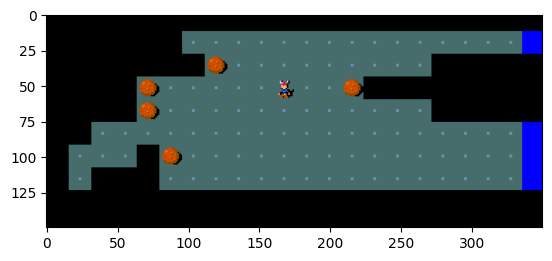

In [3]:
state, env = create_env([8]) # create the environment with fixed seed
plt.imshow(state['pixel'][100:250, 400:750]) 
game_map = state['chars'] # state of the game map
game = state['pixel']

start = get_player_location(game_map)
boulders = get_boulder_locations(game_map, [])
river_positions = find_river(env,game_map, [])
print("Agent starting position: ", start, "\nBoulders positions: ", boulders, "\nRiver positions: ", river_positions)

The optimal boulder to push into the river is determined using a heuristic that calculates the minimum total distance, taking into account both the distance between the agent and the boulders and the distance between the boulders and the river cells. The heuristic used is the Chebyshev distance <a href="#cite-chebyschev">[3]</a>. \
<img src="images/chebyshev_dist.png" alt="Chebyshev" width="150"/>

In case of a tie in the global distance metric, the boulder closest to the river is selected. This choice is motivated by the desire to have fewer boulders in front of the agent while pushing the selected boulder, thus reducing the likelihood of the agent getting blocked. This strategy not only reduces the risk of the agent getting stuck behind a boulder, but also allows the agent to explore the environment more.

In [4]:
# get the most convinient boulder to push
coordinates_min_boulder = get_best_global_distance(start, boulders, river_positions)

# show which river cell has been selected as the final target
river_target,_ = get_min_distance_point_to_points(coordinates_min_boulder[0],coordinates_min_boulder[1], river_positions)
print("Boulder to push: ", coordinates_min_boulder, "\nRiver cell target: ", river_target)

Boulder to push:  (9, 38) 
River cell target:  (7, 46)


### Agent's Strategy
As mentioned before, the agent's plan is based on the A* algorithm, using the Chebyshev distance <a href="#cite-chebyschev">[3]</a> as a heuristic function; in fact, in NetHack, the agent can move in all eight cardinal directions. In this case, the heuristic is not only admissible, but it is also a consistent one.
The boulder pushing position is the cell in which the agent has to be to push the boulder in the correct direction.

The computations are performed in this order:
* The path that the boulder has to follow to reach the correct river cell;
* The correct pushing position of the boulder;
* The path that agent has to follow to reach the pushing position.

In [5]:
path_boulder_river = a_star(game_map, coordinates_min_boulder,river_target, True, False, get_optimal_distance_point_to_point)
pushing_position = position_for_boulder_push(coordinates_min_boulder, path_boulder_river[1])[1]
path_player_to_pushing_position = a_star(game_map, start,  pushing_position,False,False, get_optimal_distance_point_to_point)

After computing the path from the boulder to the river, the agent needs to know the path to follow to push the boulder along its trajectory. Finally, the complete path that the agent must take to reach the river is obtained.

In [6]:
try:
    _, path_player_to_river = push_boulder_path(path_boulder_river) # Agent's complete path
    path_player_to_river = path_player_to_river[1:] # Remove the first element because the agent is already in the pushing position
    agent_full_path = path_player_to_pushing_position + path_player_to_river
    agent_full_path.append(path_boulder_river[-1]) # Add the river position so the agent steps where there was the river
except Exception as e:
    print("Offline A* failed:", str(e))


### Offline A* Demo
The following is a demo that shows the agent pushing the boulder into the river.


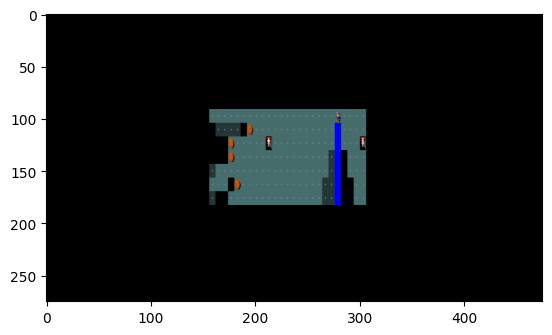

In [7]:
actions, names = actions_from_path(start, agent_full_path) # Get the actions the agent needs to perform
_ = plot_animated_sequence(env,game, game_map,actions[1:]) #Remove first action because it is the start position

### Finding the stairs
The agent can now see the stairs, find them, and go forward to complete his goal, since the river should be crossable (if the boulder did not sink).
To evaluate whether the agent has completed the goal, we use the reward system of MiniHack, which returns for each step:
* 0.0 if the agent has not completed the goal;
* -0.1 if the agent is stuck (The agent did a step but he stayied in the same position);
* 1 if the agent has stepped in the coordinates of the stairs.

The agent reached the exit


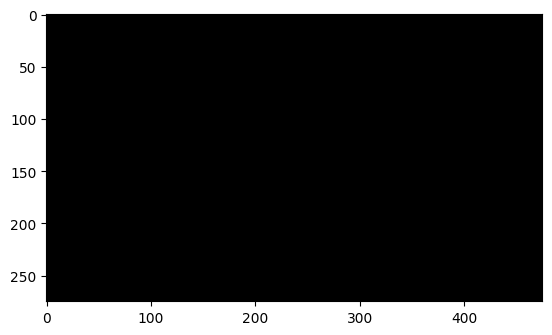

In [8]:
player_pos = get_player_location(game_map)
exit_pos = find_stairs(env, game_map)

if(exit_pos is None):
    print("The agent doesn't see the stairs --> offline A* failed")
else:
    path_to_exit = a_star(game_map, player_pos, exit_pos, False, False, get_optimal_distance_point_to_point)
    actions_to_exit,names = actions_from_path(player_pos, path_to_exit)
    rewards = plot_animated_sequence(env,game, game_map,actions_to_exit[1:]) 

if(rewards[-1] == 1):
    print("The agent reached the exit")
else:
    print("The agent didn't reach the exit")

## Second solution: Online A*
This section presents the final solution of the project, called Online A*. It is an online algorithm that allows the agent to adapt to changes in the environment.

### 

## Logic 
In this section we explain what the logic does, considering what we know about the environment

### Valid moves - get_valid_moves()
<img src="images/valid_moves_1.png" alt="Valid Moves" width="100"/>
<img src="images/valid_moves_2.png" alt="Valid Moves" width="100"/>
<img src="images/valid_moves_3.png" alt="Valid Moves" width="100"/>

The `get_valid_moves()` function is used to determine all the valid moves a player can make from a current position on a game map. The function takes five parameters:
* `game_map`: represents the game map as a matrix
* `current_position`: the current position of the agent on the map
* `target_position`: the target position of the agent on the map
* `hasBoulder`: indicates whether the agent has a boulder
* `boulder_is_obstacle`: indicates whether the boulder is considered an obstacle

The function first determines the limits of the game map. It then checks each possible move (North, East, South, West, North-East, South-East, South-West, North-West) to see if it is within the game map boundaries and not an obstacle. If the move is valid, it is added to the valid list.

The function also checks if the agent has a boulder and if the next move is a river:
* If the agent has a boulder, it can move to the next position regardless of whether it's a river or not
* If the agent doesn't have a boulder, it can only move to the next position if it's not a river.

Finally, the function returns the valid list, witch contains all the valid moves the agent can make from the current position.

### Avoid the obstacle - avoid_obstacle()
<img src="images/avoid1.png" alt="Avoid obstacle" width="100"/>
<img src="images/avoid2.png" alt="Avoid obstacle" width="100"/>
<img src="images/avoid3.png" alt="Avoid obstacle" width="100"/>
<img src="images/avoid4.png" alt="Avoid obstacle" width="100"/>

The `avoid_obstacle()` function is responsible for managing the situation when the player character in a game is stuck by an obstacle, which can be either a boulder or a river. It takes in several parameters:
* `game_map`: represents the game map as a matrix
* `player_position`: the current position of the player
* `direction`: indicates the direction the player is going
* `env`: represents the game environment.

The function begins by calling the `get_obstacle_location()` function to determine the position of the obstacle in front of the player based on their current position and direction.

Next, the function checks if the obstacle is a river or a boulder and then handles different scenarios based on the direction the player is going.

### Pushing position - position_for_boulder_push() - push_boulder_path() - get_neighbour_pushing_position

The function `position_for_boulder_push()` is used to determine the position where the agent should be in order to push a boulder from its current position to a new position. The function takes two parameters:
* `current_boulder_position`: tuple representing the current position of the boulder
* `new_boulder_position`: tuple representing the new position of the boulder

With the the help of `action_map()`, we can determine the action that the boulder needs to perform in order to move from the current position to the new position.
Finally, the function returns a tuple containing the action that the agent needs to perform (`action`) and the position where the agent should be located (`coord_map[action_name]`) in order to move the boulder.

---------------------------

The function `push_boulder_path()` takes a list of tuples representing a boulder's path as input and returns the path the agent must follows to push a boulder along its path. So, the only parameter it takes is:
* `boulder_path`: the path the boulder has to follow

The function performs some operations on the boulder's path, using the `position_for_boulder_push()` function specified before.

<img src="images/pushing1.png" alt="Pushing path" width="500"/>

---------------------------

The function `get_neighbour_pushing_position()` returns the neighbors of a given pushing position on a game map. The function takes three parameters:
* `game_map`: represents the game map as a matrix
* `pushing_position`: the pushing position
* `boulder_position`: the position of the boulder on the map

This function calculates the neighboring positions of a given pushing position on a game map, excluding positions that are obstacles or the position of a boulder.
Finally, the function returns the first neighbor in the `neighbours` list.

<img src="images/pushing2.png" alt="Near pushing position" width="500"/>

## Online A* Demo
Again, a fixed seed environment is created to show a case where the agent adapts, especially since the agent doesn't see the river in the initial state.

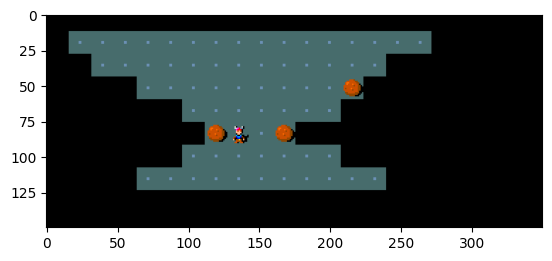

In [9]:
state, env = create_env([890])
plt.imshow(state['pixel'][100:250, 400:750]) 
game_map = state['chars']
game = state['pixel']

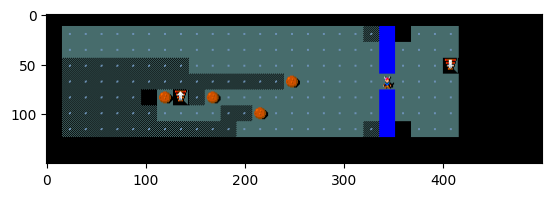

In [10]:
black_list_boulder  = [] # boulders that the agent cannot push into the river (because it is impossible)
obs, current_river_target, len = push_one_boulder_into_river(state, env, black_list_boulder, plot=True)
while current_river_target is None or obs['chars'][current_river_target] == ord("}"): # if the bulder sink re-start with another boulder
    obs, current_river_target, len = push_one_boulder_into_river(obs, env, black_list_boulder, plot=True)

game_map = obs['chars']
game_gui = obs['pixel']

#Step into the river which is now crossable
player_pos = get_player_location(game_map)
action, name = action_map(player_pos, current_river_target)
obs, _,_,_ = env.step(action)
plt.imshow(obs['pixel'][100:250, 400:900]) 


The agent reached the exit --> Online A* succeded


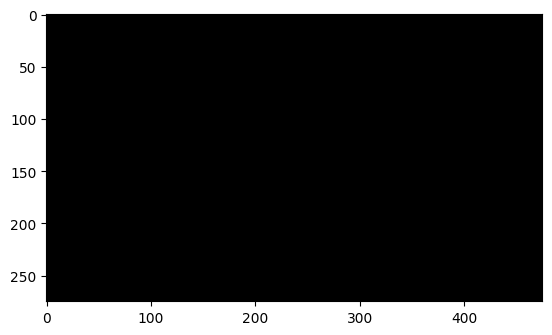

In [11]:
#Go to the stairs
game_map = obs['chars']
game_gui = obs['pixel']

player_pos = get_player_location(game_map)
exit_pos = get_exit_location(game_map) # stairs position

path_to_exit = a_star(game_map, player_pos, exit_pos, False, False, get_optimal_distance_point_to_point)
actions_to_exit,names = actions_from_path(player_pos, path_to_exit[1:])
rewards = plot_animated_sequence(env, game_gui, game_map, actions_to_exit)

if(rewards[-1] == 1):
    print("The agent reached the exit --> Online A* succeded")

## Evaluation
In this section we perform multiple trials on the two solutions showing the metrics:
* The percentage of successfully completed games out of n trials
* The average number of steps done on successful games
* The execution time on successful games

In [12]:
avg_success, avg_step, avg_time = test_classic_a_star(100, 1) # number of games, trials


Starting test: A* classic



Successfully completed:  50 / 100  =  50.0 %
Average number of steps:  16.28
Average time per success:  0.1080978536605835 



In [13]:
on_avg_success, on_avg_step, on_avg_time = test_online_a_star(100, 1)


Starting test: A* online

Successfully completed:  100 / 100  =  100.0 %
Average number of steps:  23.04
Average time per success:  0.16897990942001342 



## Results
This are the results obtained with 100 game execution.

First, a notable improvement in the success rate underscores the increased flexibility and adaptability inherent in online A*. Shifting the focus to the average number of steps, despite minor fluctuations, online A* demonstrates a remarkable ability to adapt to evolving scenarios while maintaining competitive performance. The justification for such variations is rooted in the increased complexity of the situations addressed by the solution, which necessitates occasional route adjustments without compromising overall efficiency. The online A* version takes also into account the added complexity of the agent having to go back to get another boulder after a boulder has sunk, thus increasing the number of steps performed.

Finally, although our implementation requires a relative increase in execution times, this marginal difference is considered acceptable given the significant improvements in success rate. In conclusion, an effective balance between efficiency and adaptability is evident in the data collected, confirming the validity of the modifications and establishing it as a robust option for dynamic scenarios.


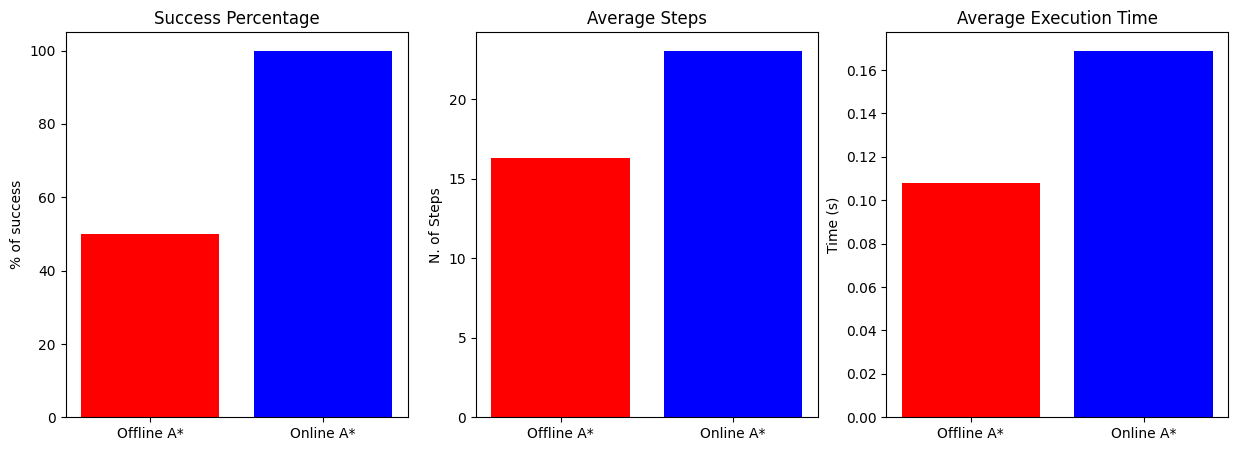

In [14]:
plot_results(avg_success, avg_step, avg_time, on_avg_success, on_avg_step, on_avg_time)

### TorchBeast
TorchBeast <a href="#cite-torch">[4]</a> , as presented in its PyTorch implementation of IMPALA (Scalable Distributed Deep-RL with Importance Weighted Actor-Learner Architectures) with variants MonoBeast and PolyBeast, offers two choices with different characteristics. While PolyBeast offers greater performance and allows training across machines, its installation process is somewhat more challenging. On the other hand, MonoBeast, which requires only Python and PyTorch (preferably version 1.2 or later), presents a more straightforward installation.

Experiments conducted by the MiniHack team on various standard environments in the MiniHack environment zoo, including the River environment used as a benchmark, are detailed in their results <a href="#cite-torch_results">[5]</a>. The team achieved an average accuracy of 99.69%, a result close to our findings. However, a direct comparison of the number of steps is challenging, as they report the total number of steps taken by the model during training.

<img src="images/torchbeast_res.png" alt="Results" width="800"/>

## Conclusions
The exploration began with a close examination of the problem and its contextual challenges. Next, an offline approach was taken to thoroughly analyze the complexity and multiple challenges of the problem. Next, an online strategy was developed to enable the agent to tackle the problem dynamically by adapting to the environment. Finally, a comprehensive analysis of both approaches was performed, evaluating successes, number of steps, and execution time. This comparison aimed at highlighting the differences with the initial approach, while emphasizing the progress made by the final solution.

## Appendix

### Teamwork 
After reaching a unanimous decision on the project, the team organized the workload into two main tasks: "path" and "logic". This approach allowed for effective pair programming within two groups, ensuring clear communication of required functionality. This structuring significantly increased initial productivity and led to the subsequent merging of the Path and Logic modules.

Following this integration, weekly meetings were established to update a pool of available tasks. Team members could then contribute independently, reserving pair programming for more challenging problems. The team shared both slides and speaking time equally in preparation for the presentation.


### Github
The GitHub repository, and the relative metrics, can be found at the following link https://github.com/JacopoRaffi/Minihack_Crossing_River.

### Relationship with the course
The focus of the project was primarily on the area of search, with a particular emphasis on informed search techniques. In particular, the implementation involved the use of the A* algorithm, a widely used informed search algorithm known for its efficiency in finding optimal paths. Additionally, the project explored the nuances between online and offline approaches, highlighting how the agent dynamically adapted to changes in the environment during its execution.

## Bibliography

<a id="cite-1">[1]</a> Minihack River Environment: https://minihack.readthedocs.io/en/latest/envs/navigation/river.html \
<a id="cite-drown">[2]</a> NetHack drowning: https://nethackwiki.com/wiki/Drowning \
<a id="cite-chebyschev">[3]</a> Deza, M.M., Deza, E. (2009). Encyclopedia of Distances. In: Encyclopedia of Distances. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-00234-2_1 \
<a id="cite-torch">[4]</a> Torchbeast: https://minihack.readthedocs.io/en/latest/agents/torchbeast.html \
<a id="cite-torch_result">[5]</a> Torchbeast Results: https://wandb.ai/minihack/minihack-navigation/groups/River-Narrow-RIDE/?workspace=user-